# Fiducial Particle Detection in LM Images

Fiducial particles/markers are used in correlated light and electron microscopy (CLEM) to enable accurate overlaying of fluorescence (LM) and electron microscopy (EM) images. The fiducial particles in LM images appear as bright spots. 

In this notebook, we **detect fiducial particles** in **LM images** using Big-FISH python package originally created for analysis of smFISH images. It includes various methods, among them also the spot detection method which we are using in this notebook. The main steps of this algorithm then are:
- **1. Spot detection** - Detection of fiducial particles using spot detection methods from Big-FISH package
- **2. Dense region decomposition** - Recognizing larger and brighter (dense) spots as clusters and estimating the number of individual fiducial particles building these clusters
- **3. Cluster detection** - Detecting the position of larger and brighter (dense) spots
- **4. Results saving** - Saving the positions of all detected fiducial particles and the positions of fiducial clusters into files

Load the necessary python libraries:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils import plot_image, list_to_dataframe, dataframe_to_xml, dataframe_to_csv, dataframe_to_pointcloud
from utils import refine_to_local_maxima, clean_close_points
import open3d as o3d
from probreg import cpd
from pathlib import Path
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


Set the path to the input EM and LM images and load them

In [2]:
input_folder = 'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles/240723_JB294_CLEM-AI4life_sample1/pos1'
test_folder = '//vironova.com/root/Users/kristinal/Documents/1Test'

EM_image_path = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_bin4_EM.tif")
LM_image_path = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_LM.tif")

print(Path(EM_image_path).exists())
print(Path(LM_image_path).exists())

output_folder = Path(os.path.join(input_folder,"output"))
output_folder.mkdir(exist_ok=True)

EMimage = stack.read_image(EM_image_path)
LMimage3 = stack.read_image(LM_image_path)     # 3 channel image
LMimage = LMimage3[:,:,1]                      # 1 channel image - only the channel with the fiducial particles

large_LMimage3 = stack.resize_image(LMimage3, EMimage.shape, method='bilinear')
large_LMimage = large_LMimage3[:,:,1]

scale_x = EMimage.shape[0]/LMimage.shape[0]
scale_y = EMimage.shape[1]/LMimage.shape[1]

# ----------------------------------------------------
print("EMimage")
print("\r shape: {0}".format(EMimage.shape))
print("\r dtype: {0}".format(EMimage.dtype))

print("LMimage:")
print("\r shape: {0}".format(LMimage3.shape))
print("\r dtype: {0}".format(LMimage3.dtype))

print("resized_LMimage:")
print("\r shape: {0}".format(large_LMimage.shape))
print("\r dtype: {0}".format(large_LMimage.dtype))

print("Scale in X direction: ", scale_x)
print("Scale in X direction: ", scale_y)

True
True
EMimage
 shape: (16118, 6109)
 dtype: uint8
LMimage:
 shape: (648, 266, 3)
 dtype: uint16
resized_LMimage:
 shape: (16118, 6109)
 dtype: uint16
Scale in X direction:  24.873456790123456
Scale in X direction:  22.966165413533833


Plot the EM image overlaid with the LM image

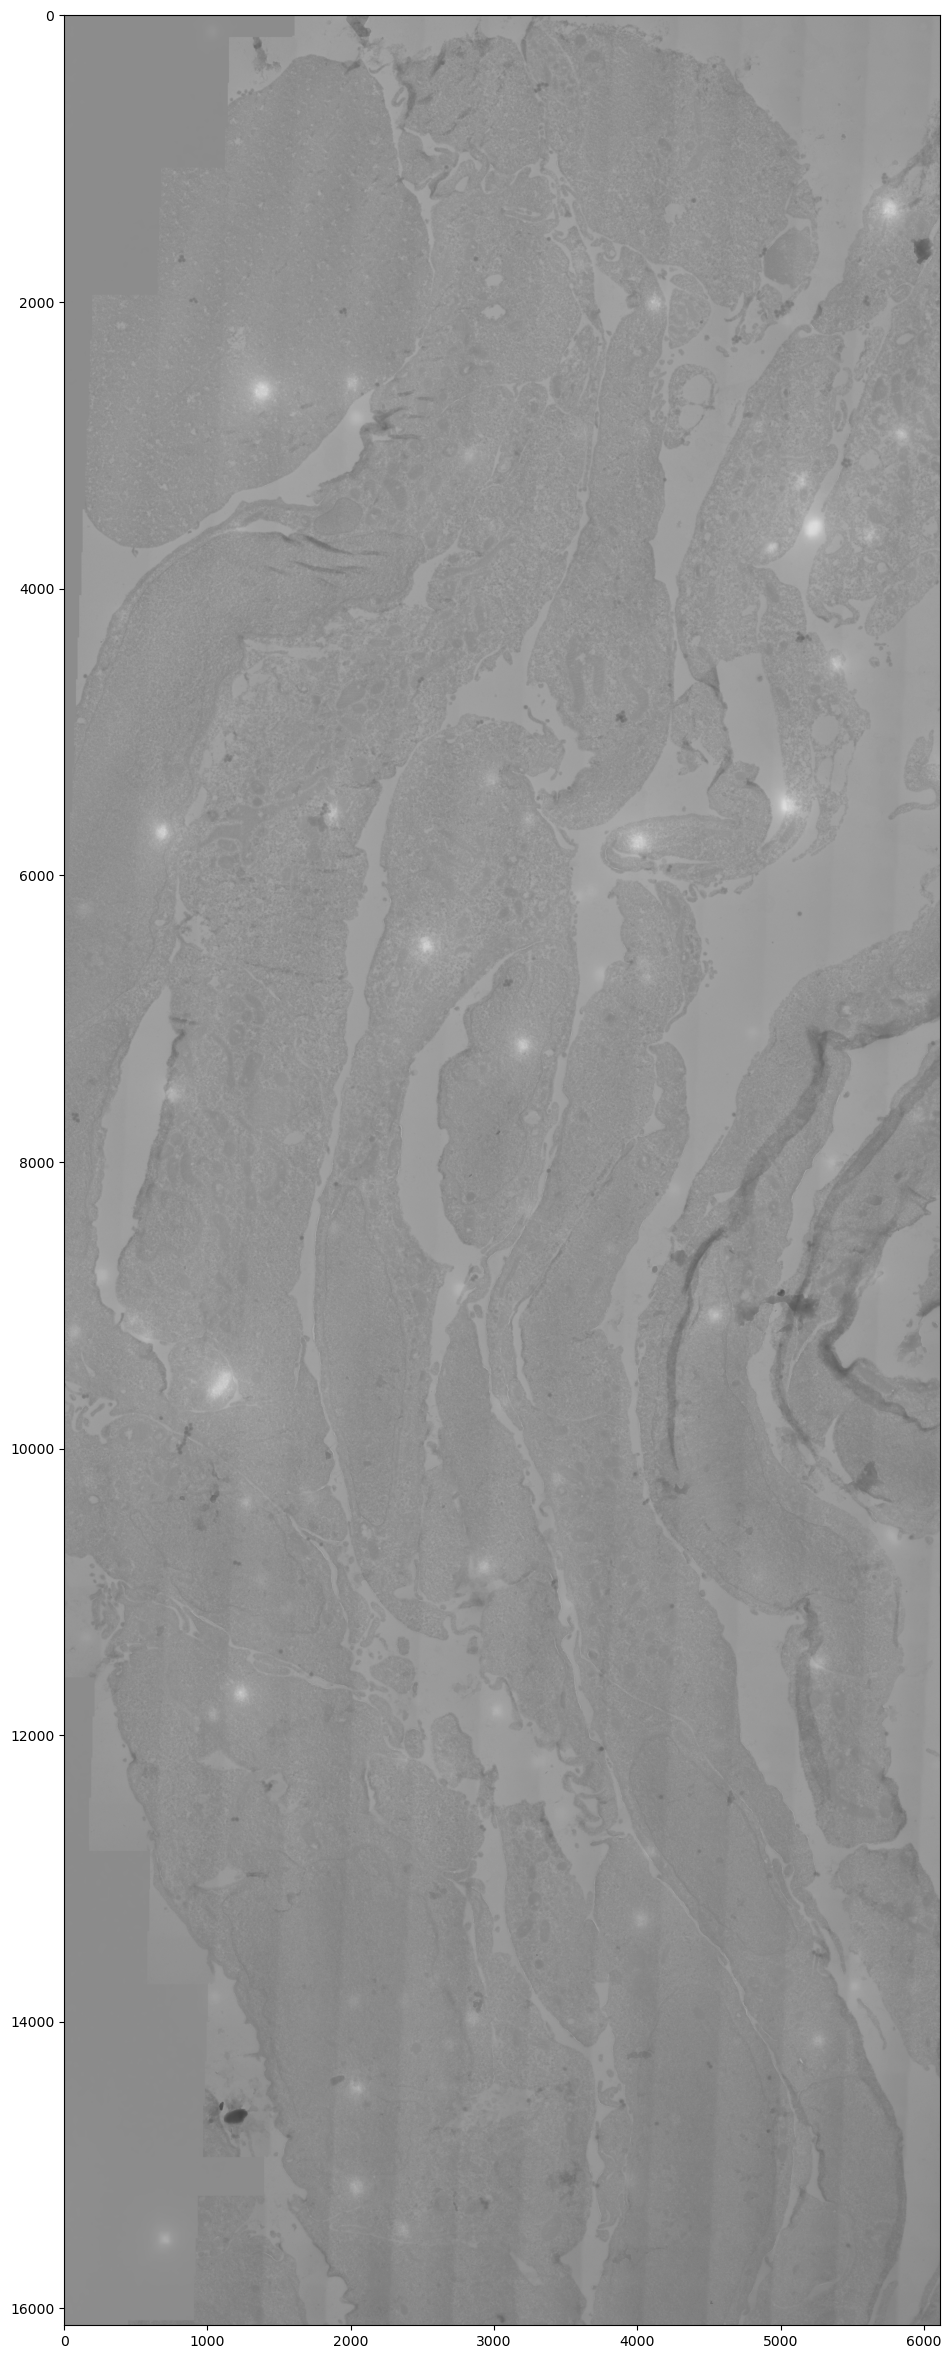

In [3]:
fig = plt.figure(figsize=(30,30))
plt.imshow(large_LMimage, cmap='gray', alpha=0.5)
plt.imshow(EMimage, cmap='gray', alpha=0.5)
plt.show()

## 1. Spot detection

We assume **spot is a local maximum** in the LM image. Three steps are required to detect them:
- Filter the LM image to enhance the signal-to-noise ratio and denoise the image (`bigfish.stack.log_filter`).
- Detect the local maximum in the filtered image (`bigfish.detection.local_maximum_detection`).
- Remove the local maximum under a fixed threshold (`bigfish.detection.spots_thresholding`). To be robust, the thresholding should be applied on the filtered image. Thus, the threshold is set relatively to the filtered image values.
- If necessary, the optimal threshold can be estimated with `bigfish.detection.automated_threshold_setting` (applied on a filtered image).

All these steps are summarized in `bigfish.detection.detect_spots` that return the 2D coordinates of the detected spots.

In [4]:
vox_size = 110  # voxel size in nanometers
spot_rad = 110 

spots, threshold = detection.detect_spots(
    images=LMimage, 
    return_threshold=True, 
    voxel_size=(vox_size, vox_size),  # in nanometer (one value per dimension zyx)
    spot_radius=(spot_rad, spot_rad))  # in nanometer (one value per dimension zyx)

# From Fiji file:
# Width:  29.2602 microns (266)
# Height:  71.2805 microns (648)
# Size:  1010K
# Resolution:  9.0908 pixels per micron
# Voxel size: 0.1100x0.1100x1 micron^3

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (162, 2)
 dtype: int64
 threshold: 355.0


Given the **voxel size** and the expected **spot radius** (in nanometer), the function `bigfish.detection.detect_spots` automatically estimates a **kernel size** for the LoG filtering and a **minimal distance** between two spots we want to be able to detect separately. It is still possible to set these parameters explicitly in order to fine-tune the detection. Internally, we approximate them as the spot radius in pixel with the function `bigfish.detection.get_object_radius_pixel`.

__Note:__ What we call spot radius in this notebook can be understood as its **Point Spread Function (PSF)**. For simplicity sake, this PSF is modelled as a 2D gaussian.

In [5]:
# spot radius
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(vox_size, vox_size), 
    object_radius_nm=(spot_rad, spot_rad), 
    ndim=2)

# LoG filter
rna_log = stack.log_filter(LMimage, sigma=spot_radius_px)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

# thresholding
threshold = detection.automated_threshold_setting(rna_log, mask)
threshold = 1500
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (109, 2)
 dtype: int64
 threshold: 1500


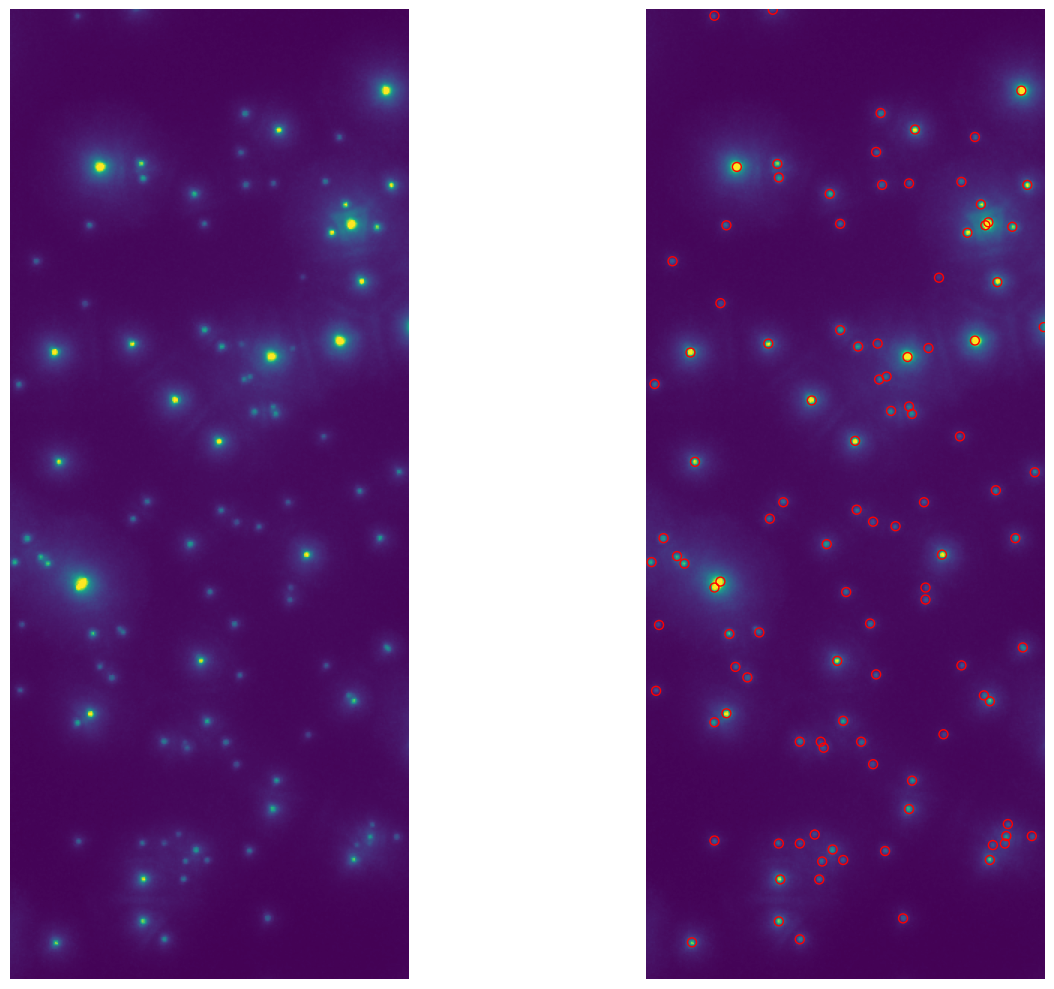

In [ ]:
plot.plot_detection(LMimage, spots, contrast=True)

## 2. Dense region decomposition 

The detection of local maximum is not able to detect individual fiducial particles clustered in a dense and bright region. We try to **decompose these regions by simulating as many spots as possible until we match the original region intensity**. Our current steps are:
- Denoise the LM image by estimating then removing its background (`bigfish.stack.remove_background_gaussian`).
- Build a reference median spot from the individual predetected spots (`bigfish.detection.build_reference_spot`).
- Fit a gaussian signal on the reference spot (`bigfish.detection.modelize_spot`).
- Detect the candidate dense regions in the denoised image - large regions brighter than the reference spot (`bigfish.detection.get_dense_region`).
- Use the fitted gaussian signal to fill as many spots in the candidate regions as possible (`bigfish.detection.simulate_gaussian_mixture`).

All these steps are summarized in `bigfish.detection.decompose_dense` that return the coordinates of the detected spots outside and inside a decomposed region, additional information about the regions themself and an image of the reference spot estimated.

In [11]:
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
    image=LMimage, 
    spots=spots, 
    voxel_size=(vox_size, vox_size), 
    spot_radius=(spot_rad, spot_rad), 
    alpha=0.25,  # alpha impacts the number of spots per candidate region
    beta=1,  # beta impacts the number of candidate regions to decompose
    gamma=5)  # gamma the filtering step to denoise the image

#spots_post_decomposition = np.unique((spots_post_decomposition), axis=0)    # remove duplicates

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (109, 2)
 dtype: int64 

detected spots after decomposition
 shape: (285, 2)
 dtype: int64


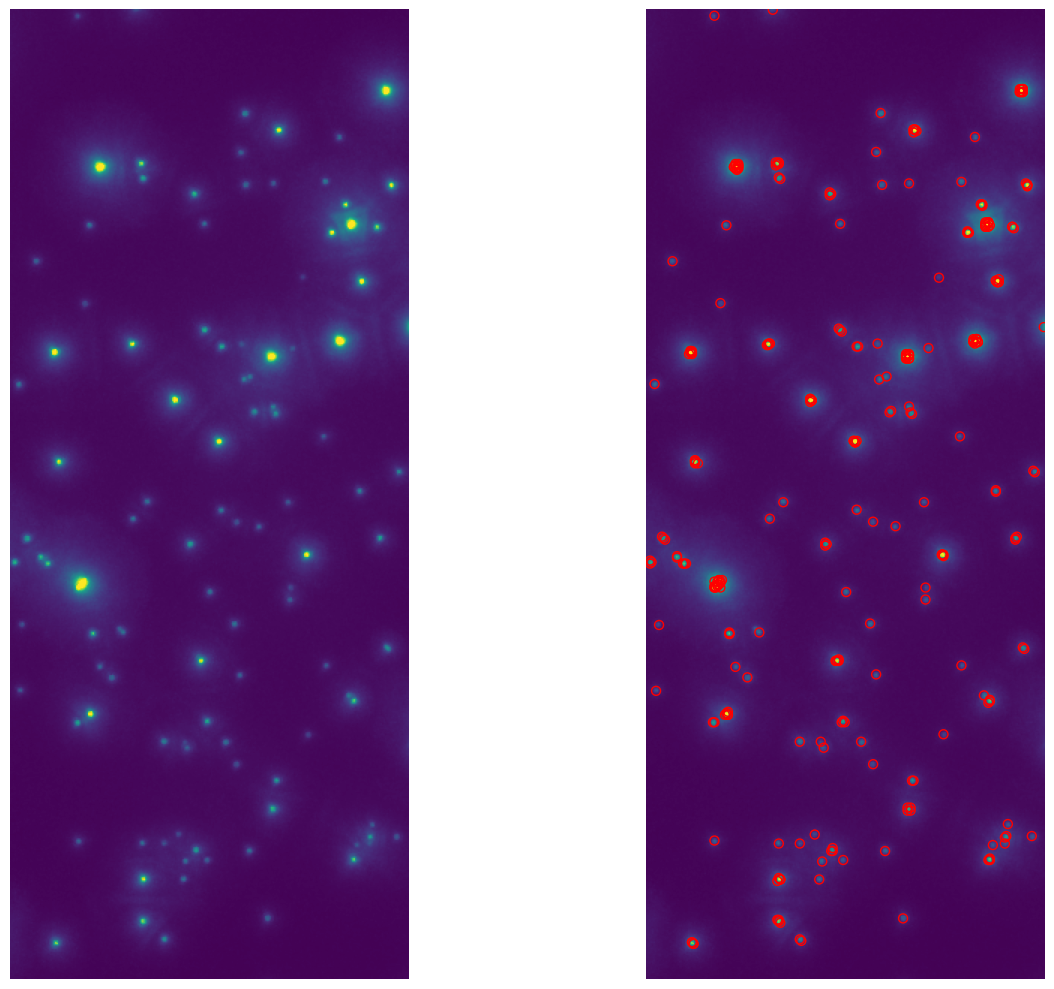

In [12]:
plot.plot_detection(LMimage, spots_post_decomposition, contrast=True)
plt.savefig('LM-all.png', dpi=300, bbox_inches='tight')
plt.close()

## 3. Clusters detection

Two spots are considered connected if they localized within a specific radius (in nanometer). Above a minimum number of connected spots, a cluster can be defined. This detection can be computed with `bigfish.detection.detect_clusters`.

In [13]:
spots_post_clustering, clusters = detection.detect_clusters(
    spots=np.asarray(spots_post_decomposition), 
    voxel_size=(110, 110), 
    radius=110, 
    nb_min_spots=2)

#spots_post_clustering = np.unique((spots_post_clustering), axis=0)    # remove duplicates
#clusters = np.unique((clusters), axis=0)    # remove duplicates

print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

detected spots after clustering
 shape: (285, 3)
 dtype: int64 

detected clusters
 shape: (51, 4)
 dtype: int64


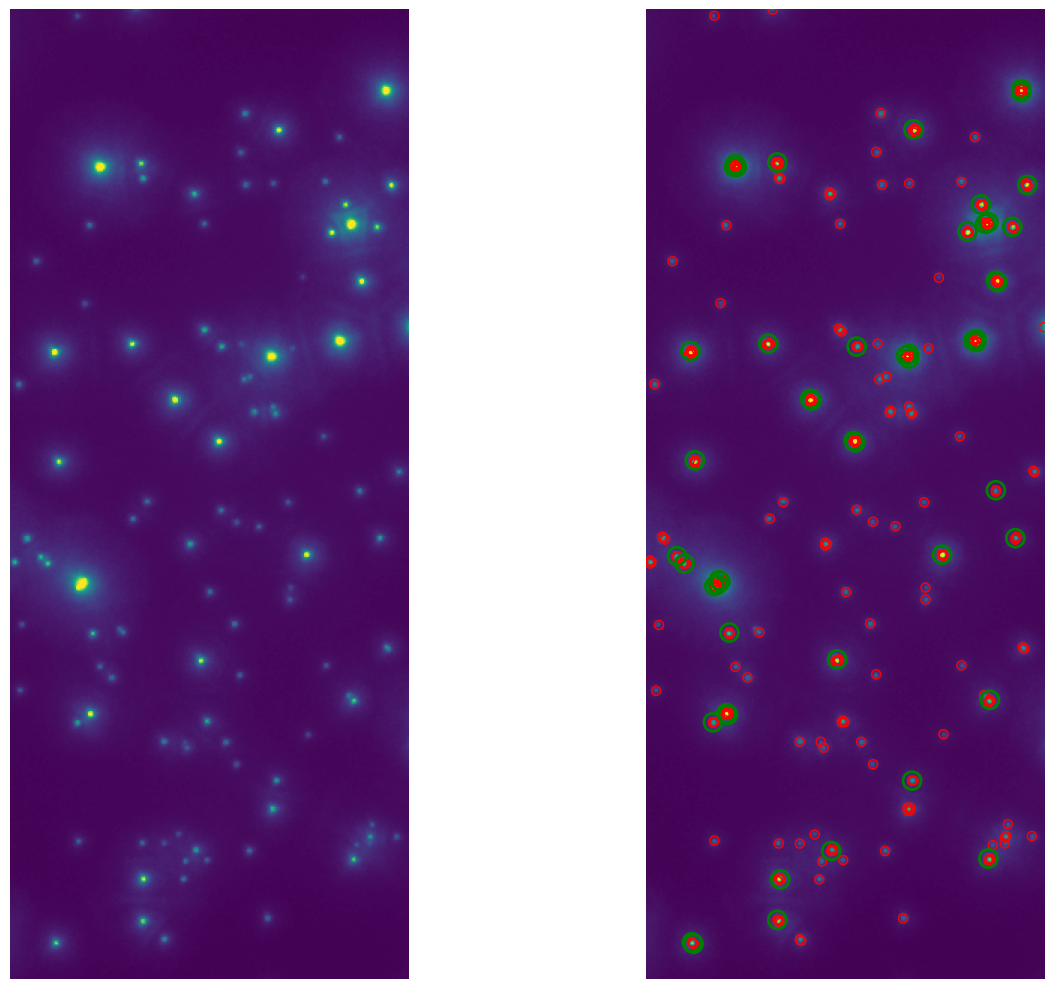

In [25]:
plot.plot_detection(LMimage, 
                    spots=[spots_post_decomposition, clusters[:, :2]], 
                    shape=["circle", "circle"], 
                    radius=[3, 6], 
                    color=["red", "green"],
                    linewidth=[1, 2], 
                    fill=[False, False], 
                    contrast=True)

## 4. Results saving

Save the LM image upscaled to the size of EM image. First save the spot locations into a pandas dataframe with columns: 'id', 'name', 'pos_x', 'pos_y'. Then convert dataframe into numpy array of coordinate pairs (X,Y), XML file and PLY file

In [15]:
stack.save_image(large_LMimage3, os.path.join(output_folder, "resized_LMimage.tif"))

In [16]:
# Save all detected fiducial particles into a Pandas dataframe and export it to different file formats
def save_spots_to_diffent_files (spots, folder, file_name, scale):    
    spots_df = list_to_dataframe(spots, os.path.join(folder, f"{file_name}_df.csv"))                                                     #str(output_folder/"source_all_df.csv")

    dataframe_to_xml(spots_df, os.path.join(folder, f"{file_name}.xml"))                      # import file for ICY ec-CLEM plugin
    #dataframe_to_xml(spots_df, os.path.join(folder, f"{file_name}_scaled.xml"), scale)                      # import file for ICY ec-CLEM plugin
    dataframe_to_pointcloud(spots_df, os.path.join(folder, f"{file_name}.ply"))                      # import file for point cloud registration using Probgreg package in Python
    dataframe_to_csv(spots_df, os.path.join(folder, f"{file_name}.csv"))                             # import file for BigWarp ImageJ plugin
    return spots_df

#df = save_spots_to_diffent_files(np.unique((spots_post_decomposition), axis=0), output_folder, "source_all", [scale_y, scale_x])  # y and x are swapped in the dataframe
#print(df)

Save the fiducial particles, regions and clusters:

In [ ]:
# Save the detected spots 'spots' as representants for regions
df = save_spots_to_diffent_files(np.unique((clean_close_points(spots, threshold=10)), axis=0), output_folder, "source_regions", [scale_y, scale_x])  # y and x are swapped in the dataframe
print(df)

# Save the 'spots_post_decomposition' as positions for all fiducial particles
df = save_spots_to_diffent_files(np.unique((clean_close_points(spots_post_decomposition, threshold=10)), axis=0), output_folder, "source_all", [scale_y, scale_x])  # y and x are swapped in the dataframe
print(df)

# Save the 'clusters'
df = save_spots_to_diffent_files(np.unique(refine_to_local_maxima(clean_close_points(clusters[:, :2], threshold=10), LMimage, window_size=5), axis=0), output_folder, "source_clusters", [scale_y, scale_x])  # y and x are swapped in the dataframe
print(df) 

### Segmenation of the regions

In [ ]:
import skimage.filters as filters
import skimage.morphology as morphology

# thresholding
threshold = filters.threshold_otsu(large_LMimage)
print(threshold)
img_thresholded = large_LMimage >= 25000

# filter by size
#img_filtered = morphology.remove_small_objects(img_thresholded, min_size=100)
#img_filtered = morphology.remove_small_holes(img_filtered)
#img_filtered = morphology.binary_opening(img_filtered, morphology.disk(2))  # opening and closing maybe not needed since it smooths the protrusions, 
#img_filtered = morphology.binary_closing(img_filtered, morphology.disk(2))  # but at the moment here to keep it as usefull code
#img_filtered = img_thresholded

# plot pre-processing
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_thresholded,cmap="gray")
ax1.set_title('Original')
plt.axis('off')

In [ ]:
plot.plot_detection(img_thresholded*255, spots_post_decomposition*[scale_x, scale_y], contrast=True)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(img_thresholded , cmap='gray', alpha=0.5)
plt.imshow(EMimage, cmap='gray', alpha=0.5)
plt.show()